In [4]:
%load_ext autoreload
%autoreload 2

import json
# import logging
import math
import multiprocessing
import os
import statistics
import time

import sys
sys.path.insert(0, "/Users/rico.meinl/Desktop/BACHELOR_THESIS/instacart2vec/source")

from gensim.matutils import argsort
from gensim.models.word2vec import Word2Vec, FAST_VERSION
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

from source.item2vec_recommender import Item2VecRecommender
from source.item2vec_embeddings import Item2VecEmbeddings
from source.data_loader import DataLoader

### JUST FOR TEST
from itertools import permutations
from scipy.sparse import dok_matrix, csr_matrix
# from baseline_recommender import ItemCoCountRecommender
from source.utils import convert_size

# logging.basicConfig(
#      format="%(levelname)s - %(asctime)s: %(message)s",
#      datefmt="%H:%M:%S",
#      level=logging.INFO,
# )

## Load Data

In [5]:
# small = "small_"
small = ""
algorithm = "item2vec"

In [6]:
data_loader = DataLoader(algorithm=algorithm,
                         small_data=(small!=""),
                         with_meta=False,
                         with_user=False,
                         use_file_iterator=True)

With Metadata: False
With User: False
Loading data...
Creating file to iterate for item2vec in sentences/item2vec/train.txt


In [ ]:
data_loader = load_data(small_data=(small!=""))

In [ ]:
train_data = data_loader["train"]
validation_data = data_loader["validation"]
test_data = data_loader["test"]
item_metadata = data_loader["metadata"]

# TEST START

In [ ]:
def generate_user_item_interactions(train_data, n_items, product_mapping_dict):
    user_transactions_map = {}
    user_item_frequency = {}
    item_frequency = {}
    for index, row in enumerate(train_data):
        # user id is always first in list, then all the purchased items
        user_id = row[0]
        items = [product_mapping_dict[i] for i in row[1:]]
        temp_transactions = user_transactions_map.get(user_id, [])
        temp_transactions.append(index)
        user_transactions_map[user_id] = temp_transactions

        temp_item_frequency = user_item_frequency.get(user_id, {})
        for item in items:
            temp_item_frequency[item] = temp_item_frequency.get(item, 0) + 1
            item_frequency[item] = item_frequency.get(item, 0) + 1
        user_item_frequency[user_id] = temp_item_frequency
        

    return user_transactions_map, user_item_frequency, item_frequency

In [ ]:
def add_item_pairs_to_matrix(data, product_mapping_dict):
    item_interactions_dict = {}
    
    for index, row in enumerate(data):
        # user id is always first in list, then all the purchased items
        user_id = row[0]
        items = [product_mapping_dict[i] for i in row[1:]]
        
        for item, paired_item in permutations(set(items), r=2):
            if item != paired_item:
                key = (item, paired_item)
                item_interactions_dict[key] = item_interactions_dict.get(key, 0) + 1
            
    return item_interactions_dict

In [ ]:
def generate_item_item_interactions(train_data, n_items, product_mapping_dict, item_frequency):
    # Create dictionary of item-item pairs and the number of times they appeared together in a basket
    item_interactions_dict = add_item_pairs_to_matrix(data=train_data, product_mapping_dict=product_mapping_dict)
    
    # divide each item pair (item1, item2) by the total number of appearances of item1
    for k in item_interactions_dict.keys():
        item_interactions_dict[k] /= item_frequency[k[0]]

    print("Generating the item, item dok matrix...")
    item_interactions_dok = dok_matrix((n_items, n_items), dtype=np.float32)

    for k, v in item_interactions_dict.items():
        item_interactions_dok[k] = v

    del item_interactions_dict

    print("Turning the item, item dok matrix into a csr matrix...")
    item_interactions_csr = item_interactions_dok.tocsr()
    print(convert_size(item_interactions_csr.data.nbytes + item_interactions_csr.indptr.nbytes + item_interactions_csr.indices.nbytes))
    
    del item_interactions_dok

    return item_interactions_csr

# TEST END

In [ ]:
# Create product key conversion if not exists
product_key_conversion = get_product_key_conversion(metadata=item_metadata, save=False)
print(product_key_to_meta(product_key_conversion, "1"))
print(product_key_to_name(product_key_conversion, "1"))

## Prepare data

In [ ]:
def create_sentences(data, stage, is_np_array=False, overwrite=True):
    # Build train set
    filepath = f"sentences/{algorithm}/{stage}.txt"
    if overwrite:
        print(
            f"Creating sentences for the {stage} stage for item2vec in {filepath}"
        )
        with open(filepath, "w") as file:
            if is_np_array:
                for transaction in data:
                    # user id is always first in list, then all the purchased items
                    user_id = transaction[0]
                    items = transaction[1:]
                    if len(items) > 0:
                        file.write(" ".join(map(str, items)) + "\n")
            else:
                for i, row in data.iterrows():
                    file.write(' '.join(map(str, row["product_id"])) + "\n")
                
    return filepath

In [ ]:
class SentenceIterator(object):
    def __init__(self, sentences_filepath):
        self.sentences_filepath = sentences_filepath
                    
    def __iter__(self):
        assert os.path.exists(self.sentences_filepath)
        for line in open(self.sentences_filepath):
            yield line.split()

In [ ]:
# train_sentences_path = create_sentences(train_data, "train", overwrite=False)
train_sentences_path = create_sentences(train_data, f"{small}train", is_np_array=True, overwrite=True)
train_sentences = SentenceIterator(sentences_filepath=train_sentences_path)

In [ ]:
train_data_iter = TransactionDataIterator(data=train_data)

## Training Embeddings

In [ ]:
def train_model(
        train_data,
        epochs,
        embedding_size,
        window_size,
        ns_exponent,
        number_of_negative_samples,
        min_count,
        sample,
        save=False,
    ):
        print(f"Fast Version: {FAST_VERSION}")

        model = Word2Vec(
            train_data,
            sg=1,
            size=embedding_size,
            window=window_size,
            min_count=min_count,
            compute_loss=True,
            workers=multiprocessing.cpu_count(),
            hs=0,
            sample=sample,
            negative=number_of_negative_samples,
            ns_exponent=ns_exponent,
            iter=epochs,
        )
        
        model.init_sims(replace=True)

        if save:
            model.save(f"models/{algorithm}/embeddings.model")
            print("Model Saved")

        return model

In [8]:
embeddings = Item2VecEmbeddings(algorithm="item2vec",
                                product_key_conversion=data_loader.product_key_conversion,
                                with_meta=False,
                                with_user=False)

embeddings.load_model(model_path=f"models/{algorithm}/embeddings_trained.model")

# embeddings.train_model(
#                     data_loader.train_data_iterator,
#                     epochs=1,
#                     embedding_size=128,
#                     window_size=5, # 100,
#                     min_count=10,
#                     number_of_negative_samples=7,
#                     sample=0.01,
#                     ns_exponent=0.5,
#                     save=False
#                 )

# model = train_model(
#                     train_sentences,
#                     epochs=1,
#                     embedding_size=128,
#                     window_size=100,
#                     min_count=10,
#                     number_of_negative_samples=7,
#                     sample=0.01,
#                     ns_exponent=0.5,
#                     save=True,
#                 )

# model = Word2Vec.load(f"models/{algorithm}/embeddings.model")

Loading Word2Vec model...


In [ ]:
# Create a matrix filled with embeddings of all items considered.
mapping = {item_key: index for index, item_key in enumerate(model.wv.index2word)}
mapping_back = {index: item_key for item_key, index in mapping.items()}
embedding = [model.wv[key] for key in mapping.keys()]

# embedding = [model.wv[key] for key in model.wv.vocab.keys()]
# context_vectors = [vector for vector in model.trainables.syn1neg]
# mapping = {item_key: index for index, item_key in enumerate(model.wv.vocab.keys())}
# mapping_back = {index: item_key for item_key, index in mapping.items()}

## Category and Aisle Prediction

In [ ]:
def predict_labels(classifier, x, y, test_size=0.5):
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)

    classifier.fit(x_train, y_train)
    y_predictions = classifier.predict(x_test)

    # accuracy = round(accuracy_score(y_predictions, y_test), 3)
    # precision = round(precision_score(y_predictions, y_test, average="weighted"), 3)
    # recall = round(recall_score(y_predictions, y_test, average="weighted"), 3)
    f1_micro = round(f1_score(y_predictions, y_test, average="micro"), 4)
    f1_macro = round(f1_score(y_predictions, y_test, average="macro"), 4)
    f1_weighted = round(f1_score(y_predictions, y_test, average="weighted"), 4)

    return f1_micro, f1_macro, f1_weighted

In [ ]:
def evaluate_embeddings(embedding, mapping, product_key_conversion, k_neighbors=10):
    y_category_list = []
    y_aisle_list = []

    for key in mapping.keys():
        y_category_list.append(product_key_to_meta(product_key_conversion, key).split("\t")[1])
        y_aisle_list.append(product_key_to_meta(product_key_conversion, key).split("\t")[2])

    # K Neighbors Classifier
    k_neighbors_classifier = KNeighborsClassifier(n_neighbors=k_neighbors, 
                                                  n_jobs=-1)

    category_f1 = predict_labels(classifier=k_neighbors_classifier, 
                                 x=embedding, 
                                 y=y_category_list)
    aisle_f1 = predict_labels(classifier=k_neighbors_classifier, 
                              x=embedding, 
                              y=y_aisle_list)

    print(f"Category - Micro: {category_f1[0]}, Macro: {category_f1[1]}, Weighted: {category_f1[2]}")
    print(f"Aisle    - Micro: {aisle_f1[0]}, Macro: {aisle_f1[1]}, Weighted: {aisle_f1[2]}")
    
    return category_f1, aisle_f1

In [ ]:
category_f1, aisle_f1 = embeddings.evaluate_embeddings(k_neighbors=10)

# category_f1, aisle_f1 = evaluate_embeddings(embedding=embedding, 
#                                             mapping=mapping, 
#                                             product_key_conversion=product_key_conversion,
#                                             k_neighbors=10)

In [ ]:
# Small Data
# 5 epochs (64 dims)
# Micro: 0.5179, Macro: 0.3083, Weighted: 0.567
# Micro: 0.3111, Macro: 0.1314, Weighted: 0.367

# # 5 epochs (32 dims)
# Micro: 0.559, Macro: 0.3312, Weighted: 0.6019
# Micro: 0.3231, Macro: 0.1447, Weighted: 0.3697

# 5 epochs (128 dims)
# Micro: 0.4068, Macro: 0.1842, Weighted: 0.4701
# Micro: 0.2479, Macro: 0.1, Weighted: 0.3145

# 5 epochs (128 dims) using model.init_sims()
# Micro: 0.5846, Macro: 0.3872, Weighted: 0.6137
# Micro: 0.3487, Macro: 0.1544, Weighted: 0.3917

# 5 epochs (256 dims)
# Micro: 0.3316, Macro: 0.1322, Weighted: 0.4191
# Micro: 0.2017, Macro: 0.0816, Weighted: 0.265

# 15 epochs
# Micro: 0.4803, Macro: 0.2815, Weighted: 0.5265
# Micro: 0.2974, Macro: 0.1203, Weighted: 0.3548

# 25 epochs
# Micro: 0.4855, Macro: 0.2555, Weighted: 0.5369
# Micro: 0.3043, Macro: 0.1338, Weighted: 0.3557

# 100 epochs
# Micro: 0.4684, Macro: 0.2413, Weighted: 0.5284
# Micro: 0.2923, Macro: 0.1236, Weighted: 0.3459

# TEST START: CO-COUNT:

In [ ]:
user_transactions_map, user_item_frequency, item_frequency = generate_user_item_interactions(train_data=train_data, 
                                                                                             n_items=n_items, 
                                                                                             product_mapping_dict=mapping)

In [ ]:
sparse_item_item_matrix = generate_item_item_interactions(train_data=train_data, 
                                                          n_items=n_items, 
                                                          product_mapping_dict=mapping, 
                                                          item_frequency=item_frequency)

In [ ]:
item_co_count_baseline = ItemCoCountRecommender(n_items=n_items, item_co_count_matrix=sparse_item_item_matrix, product_mapping_dict=mapping)

In [ ]:
# Validation Set and Test Set
k = 10
hit_rate_at_k_val, ndcg_at_k_val = item_co_count_baseline.evaluate(validation_data, k=k)
print(f"Hit Rate @ {k} on Validation Set: {hit_rate_at_k_val}")
print(f"NDCG @ {k} on Validation Set: {ndcg_at_k_val}")

# hit_rate_at_k_test, ndcg_at_k_test = item2vec_recommender.evaluate(test_set, k=k)
# print(f"Hit Rate @ {k} on Test Set: {hit_rate_at_k_test}")
# print(f"NDCG @ {k} on Test Set: {ndcg_at_k_test}")

In [ ]:
# Validation Set and Test Set
k = 10
hit_rate_at_k_val, ndcg_at_k_val = evaluate(item_co_count_baseline, validation_data, k=k)
print(f"Hit Rate @ {k} on Validation Set: {hit_rate_at_k_val}")
print(f"NDCG @ {k} on Validation Set: {ndcg_at_k_val}")

# hit_rate_at_k_test, ndcg_at_k_test = item2vec_recommender.evaluate(test_set, k=k)
# print(f"Hit Rate @ {k} on Test Set: {hit_rate_at_k_test}")
# print(f"NDCG @ {k} on Test Set: {ndcg_at_k_test}")

## Item2Vec Recommender

In [10]:
item2vec_recommender = Item2VecRecommender(algorithm="item2vec",
                                           item_key_mapping=embeddings.mapping,
                                           user_item_frequency=data_loader.user_item_frequency,
                                           embedding_vectors=embeddings.embedding_vectors, 
                                           context_vectors=embeddings.context_vectors)
print(item2vec_recommender.context_vectors.shape)

# item2vec_recommender = Item2VecRecommender(algorithm="item2vec",
#                                            item_key_mapping=mapping,
#                                            user_item_frequency=user_item_frequency,
#                                            embedding_vectors=model.wv.vectors, 
#                                            context_vectors=model.trainables.syn1neg)
# print(item2vec_recommender.context_vectors.shape)

(41388, 128)


# TEST START

In [ ]:
test_orders_df = pd.read_csv("data/orders.csv")[
    ["order_id", "user_id", "order_number", "eval_set"]
]
# remove the orders belonging to the test set, as we don't have those transactions
test_orders_df = test_orders_df[test_orders_df.eval_set == "test"]
test_orders_df["user_id"] = test_orders_df["user_id"].apply(lambda x: f"user_{x}")
test_orders_df.head()

In [ ]:
predicted_products = []
threshold = 0.0

users_to_evaluate = list(orders_df["user_id"].values)
orders_to_evaluate = list(orders_df["order_id"].values)
for user_id in users_to_evaluate:
    if user_id in item2vec_recommender.user_item_frequency:
        given_item_ids = list(item2vec_recommender.user_item_frequency[user_id].keys())
        item_scores = item2vec_recommender.predict_items(user_id=user_id, given_items=given_item_ids)
        predicted_products.append(' '.join(map(str, [int(item2vec_recommender.reverse_item_key_mapping[i[0]].strip("product_")) for i in np.argwhere(item_scores >= threshold)])))
    else:
        predicted_products.append([])

In [ ]:
lengths = [len(i.split(" ")) for i in predicted_products]
print(float(sum(lengths)) / len(lengths)) 

In [ ]:
results = pd.DataFrame({'order_id': orders_to_evaluate, 'products': predicted_products})
results.head(10)

In [ ]:
results.to_csv("submission.csv", index=None)

In [ ]:
# 1.4699743   0.4699743   0.34427163  0.338732    0.27990076  0.27013123 0.13240743  0.13183826 -0.17400616 -0.17414978 -0.88618755
# 0.0 -> 29.53 avg length

In [ ]:
# np.allclose(np.array([model.wv[model.wv.index2word[i]] for i in range(len(model.wv.vectors))]), model.wv.vectors)
# model.wv.vectors
# model.trainables.syn1neg
# Have the same index - vector mapping
# model.wv.index2word gives the word for the index
# mapping: word to index
# reverse mapping: index to word

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
def _l2_norm(m, replace=False):
    dist = np.sqrt((m ** 2).sum(-1))[..., np.newaxis]
    if replace:
        m /= dist
        return m
    else:
        return (m / dist).astype(np.float32)

In [23]:
def min_max_scaling(x, min_value=0, max_value=1):
    x_std = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    x_scaled = x_std * (max_value - min_value) + min_value
    
    return x_scaled

In [28]:
def predict_items(recommender, user_id, given_items, alpha):
        candidate_list = []
        # map the items word to its index
        target_items = [
            recommender.item_key_mapping[key]
            if (isinstance(key, str) and key.startswith("product"))
            else key
            for key in given_items
        ]
        # slice the word vectors array to only keep the relevant items
        item_embeddings = recommender.embedding_vectors[target_items]

        mean_basket_vector = np.mean(item_embeddings, 0)

        # complementary items need to be calculated via dot product not cosine similarity
        distances = np.dot(recommender.context_vectors, mean_basket_vector)
        
        candidate_list = np.random.rand(recommender.n_items) * 1e-2

        if user_id in recommender.user_item_frequency:
            for (item_index, frequency) in recommender.user_item_frequency[user_id].items():
                if item_index in recommender.item_key_mapping:
                    candidate_list[recommender.item_key_mapping[item_index]] += frequency
                    
        candidate_list = min_max_scaling(x=candidate_list, min_value=-2.5, max_value=2.5)

        candidate_scores = (distances * (1 - alpha)) + (
            candidate_list * (alpha)
        )

        return candidate_scores

In [29]:
def evaluate_transaction(recommender, user_id, given_items, test_items, alpha, k=20):
        # get the predicted items and their scores
        item_scores = predict_items(recommender, user_id=user_id, given_items=given_items, alpha=alpha)
        # create a list of item scores
        # predicted_item_scores = np.array(list(item_scores.values()))
        # create a mapping for items to index in the scores list
        # item_indices = {key: index for index, key in enumerate(item_scores.keys())}
        
        
        # separate the target items from the other items
        negative_index = np.ones(recommender.n_items)
        mask_items = [recommender.item_key_mapping[key] for key in test_items]
        negative_index[mask_items] = 0
        target_item_scores = item_scores[mask_items]
        negative_items = item_scores[negative_index>0]
        
        # calculate the auc and ndcg
        n_negative = len(negative_items)
        false_predictions = (target_item_scores.reshape(1, len(target_item_scores)) <= negative_items.reshape(n_negative, 1)).sum(axis=0)
        auc = (n_negative - false_predictions) / n_negative
        ndcg = 1.0/np.log2(2 + false_predictions)
        
        # Precision and Recall @ K
        top_k_items = argsort(item_scores, topn=k, reverse=True)
        recall_at_k = recommender.recall(mask_items, top_k_items, k=k)
        precision_at_k = recommender.precision(mask_items, top_k_items, k=k)
        
        return auc, ndcg, recall_at_k, precision_at_k

In [30]:
def evaluate(recommender, test_transactions, alpha, k=10, within_basket=True):
        start_time = time.time()
        
        # more efficient than interating over numpy array
        test_transactions = list(test_transactions)
        metrics = []
        min_transaction_items = 2
        # after removing transactions with less than MIN_TRANSACTION_ITEMS
        actual_transaction_length = len(test_transactions)
        print(f"{actual_transaction_length} transactions to evaluate.")
        
        for test_transaction in test_transactions:
            # user id is always first in list, then all the purchased items
            user_id = test_transaction[0]
            items = [item for item in test_transaction[1:] if item in recommender.item_key_mapping]
            
            if within_basket:
                if len(items) < min_transaction_items:
                    actual_transaction_length -= 1
                    continue

                half = math.ceil(len(items) / 2)
                given_item_ids = items[:half] # given items
                hold_out_item_ids = items[half:] # test items
            else:
                if user_id not in recommender.user_item_frequency or len(items) < min_transaction_items:
                    actual_transaction_length -= 1
                    continue
                given_item_ids = list(recommender.user_item_frequency[user_id].keys())
                given_item_ids = [item for item in given_item_ids if item in recommender.item_key_mapping]
                hold_out_item_ids = items
            
            _auc, _ndcg, _recall_at_k, _precision_at_k = evaluate_transaction(recommender, 
                                                                              user_id=user_id, 
                                                                              given_items=given_item_ids, 
                                                                              test_items=hold_out_item_ids,
                                                                              alpha=alpha,
                                                                              k=k)
            metrics.append([_auc.mean(), _ndcg.mean(), _recall_at_k, _precision_at_k])

        actual_transaction_length = len(metrics)
        metrics = np.array(metrics).mean(axis=0)
        auc = round(metrics[0], 4)
        ndcg = round(metrics[1], 4)
        recall_at_k = round(metrics[2], 4)
        precision_at_k = round(metrics[3], 4)

        print(f"Evaluated {actual_transaction_length} transactions.")
        print(f"Took {round((time.time()-start_time)/60., 3)} minutes.")
        
        print(f"AUC:              {auc}")
        print(f"NDCG:             {ndcg}")
        print(f"Recall at {k}:     {recall_at_k}")
        print(f"Precision at {k}:  {precision_at_k}")

        return auc, ndcg, recall_at_k, precision_at_k

In [ ]:
# Validation Set and Test Set
val_auc, val_ndcg, val_recall, val_precision = evaluate(item2vec_recommender, 
                                                        data_loader.validation_data, 
                                                        k=10, 
                                                        within_basket=True)

In [31]:
alphas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for alpha in alphas:
    print(f"\nAlpha: {alpha}")
    val_auc, val_ndcg, val_recall, val_precision = evaluate(item2vec_recommender, 
                                                            data_loader.validation_data, 
                                                            alpha=alpha,
                                                            k=10, 
                                                            within_basket=True)

    val_auc, val_ndcg, val_recall, val_precision = evaluate(item2vec_recommender, 
                                                            data_loader.validation_data, 
                                                            alpha=alpha,
                                                            k=10, 
                                                            within_basket=False)


Alpha: 0.0
206209 transactions to evaluate.
Evaluated 195194 transactions.
Took 11.203 minutes.
AUC:              0.9549
NDCG:             0.1558
Recall at 10:     0.0795
Precision at 10:  0.0335
206209 transactions to evaluate.


/Users/rico.meinl/opt/miniconda3/envs/instacart2vec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rico.meinl/opt/miniconda3/envs/instacart2vec/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/rico.meinl/opt/miniconda3/envs/instacart2vec/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal


Evaluated 195194 transactions.
Took 12.436 minutes.
AUC:              0.9653
NDCG:             0.1755
Recall at 10:     0.1061
Precision at 10:  0.0999

Alpha: 0.1
206209 transactions to evaluate.
Evaluated 195194 transactions.
Took 10.448 minutes.
AUC:              0.9625
NDCG:             0.1917
Recall at 10:     0.1491
Precision at 10:  0.0577
206209 transactions to evaluate.
Evaluated 195194 transactions.
Took 12.246 minutes.
AUC:              0.972
NDCG:             0.2644
Recall at 10:     0.236
Precision at 10:  0.2133

Alpha: 0.2
206209 transactions to evaluate.
Evaluated 195194 transactions.
Took 12.537 minutes.
AUC:              0.9659
NDCG:             0.2149
Recall at 10:     0.1983
Precision at 10:  0.0728
206209 transactions to evaluate.
Evaluated 195194 transactions.
Took 12.607 minutes.
AUC:              0.9743
NDCG:             0.3034
Recall at 10:     0.2948
Precision at 10:  0.2658

Alpha: 0.3
206209 transactions to evaluate.
Evaluated 195194 transactions.
Took 10.71

In [20]:
min_frequency = 1000000
max_frequency = 0

for user, items in item2vec_recommender.user_item_frequency.items():
    if min(items.values()) < min_frequency:
        min_frequency = min(items.values())
    if max(items.values()) > max_frequency:
        max_frequency = max(items.values())

In [21]:
min_frequency, max_frequency

(1, 98)

In [ ]:
# Within basket
# AUC:              0.8007
# NDCG:             0.2058
# Recall at 10:     0.1411
# Precision at 10:  0.0408

# Using most similar items rather than most complementary (no difference when using _l2_norm)
# AUC:              0.6823
# NDCG:             0.1427
# Recall at 10:     0.0387
# Precision at 10:  0.0087

# Next basket
# AUC:              0.8389
# NDCG:             0.2155
# Recall at 10:     0.1501
# Precision at 10:  0.0991

# Using most similar items rather than most complementary (no difference when using _l2_norm)
# AUC:              0.7772
# NDCG:             0.1942
# Recall at 10:     0.1112
# Precision at 10:  0.0537

In [ ]:
# 10 transactions to evaluate.
# Computing scores.
# Evaluated 10 transactions.
# AUC on Validation Set:  0.9809
# NDCG on Validation Set: 0.1754
# BEFORE: Took 0.01186 minutes.
# AFTER:  Took 0.00063 minutes.

# 100 transactions to evaluate.
# Evaluated 93 transactions.
# AUC on Validation Set:  0.9487
# NDCG on Validation Set: 0.1507
# BEFORE: 0.09535 minutes.
# AFTER:  0.00746 minutes.

# 1000 transactions to evaluate.
# Evaluated 940 transactions.
# Took 
# AUC on Validation Set:  0.9472
# NDCG on Validation Set: 0.15
# BEFORE: 0.8003 minutes.
# AFTER:  0.04389 minutes.

# 206209 transactions to evaluate.
# Evaluated 195194 transactions.
# AUC on Validation Set: 0.9471
# NDCG on Validation Set: 0.1518
# Using np array:     7.95427 minutes.
# Using python list:  7.405 minutes.

In [ ]:
# Normal Run, popping out last item
# Hit Rate @ 10 on Validation Set: 0.1372
# NDCG @ 10 on Validation Set: 0.0751

# Popping out random item (5 runs, mean & stddev)
# Hit Rate @ 10 on Validation Set: 0.1810 +/- 0.0023
# NDCG @ 10 on Validation Set: 0.1049 +/- 0.0012
    
###################################################################

# 5 epochs
# Hit Rate @ 10 on Validation Set: 0.023
# NDCG @ 10 on Validation Set:     0.0106

# 15 epochs
# Hit Rate @ 10 on Validation Set: 0.0232
# NDCG @ 10 on Validation Set:     0.0106

###################################################################
# (from here used recommender.embeddings[key])

# 5 epochs 
# Hit Rate @ 10 on Validation Set: 0.0788
# NDCG @ 10 on Validation Set: 0.0389

# 5 epochs (switched the two inputs in the np.dot function)
# Hit Rate @ 10 on Validation Set: 0.0788
# NDCG @ 10 on Validation Set: 0.0389

# 5 epochs, 32 dims (if not otherwise specified, other ones are 64)
# Hit Rate @ 10 on Validation Set: 0.0745
# NDCG @ 10 on Validation Set: 0.0354

# 5 epochs, 128 dims
# Hit Rate @ 10 on Validation Set: 0.0846
# NDCG @ 10 on Validation Set: 0.044

# 5 epochs, 128 dims, using init_sims()
# Hit Rate @ 10 on Validation Set: 0.0853
# NDCG @ 10 on Validation Set: 0.0437

# 5 epochs, 256 dims
# Hit Rate @ 10 on Validation Set: 0.0894
# NDCG @ 10 on Validation Set: 0.0469

# 5 epochs (using l2 norm)
# Hit Rate @ 10 on Validation Set: 0.0765
# NDCG @ 10 on Validation Set: 0.0368

# 5 epochs (using l2 norm, switched the two inputs in the np.dot function)
# Hit Rate @ 10 on Validation Set: 0.0654
# NDCG @ 10 on Validation Set: 0.0332

# 15 epochs
# Hit Rate @ 10 on Validation Set: 0.0804
# NDCG @ 10 on Validation Set: 0.0398

# 25 epochs (used recommender.embeddings[key])
# Hit Rate @ 10 on Validation Set: 0.0803
# NDCG @ 10 on Validation Set: 0.0398

# 100 epochs (used recommender.embeddings[key])
# Hit Rate @ 10 on Validation Set: 0.0814
# NDCG @ 10 on Validation Set: 0.0408

# Baseline (Co-Count)
# Hit Rate @ 10 on Validation Set: 0.1248
# NDCG @ 10 on Validation Set:     0.0651

In [ ]:
def get_complementary_item2vec(item, recommender, k):
    print(f'{k} most complementary items to {product_key_to_name(item)}')
    
    item_embeddings = [recommender.embedding[item]]

    if len(item_embeddings) > 0:
        mean_basket_vector = np.mean(item_embeddings, 0)
        
        # complementary items need to be calculated via dot product not cosine similarity
        distances = np.dot(mean_basket_vector, recommender.context_vectors.T)
        # sorted distances from largest to smallest
        candidate_list = argsort(distances, topn=50, reverse=True)
        
    # to get the distance: float(dists[item])
    indices = [product_key_to_name(recommender.embedding.index2word[i]) for i in candidate_list[:k]]
        
    print(indices)

In [ ]:
def get_complementary_co_count(item, sparse_item_item_matrix, k):
    print(f'{k} most complementary items to {product_key_to_name(item)}')
    mapped_item = mapping[item]
    co_count_sum = np.asarray(sparse_item_item_matrix.getrow(mapped_item).todense())[0]

    candidate_indices = np.argsort(co_count_sum)[::-1][:k]
    candidate_list = [product_key_to_name(mapping_back[candidate_index]) for candidate_index in candidate_indices]
    
    print(candidate_list)

In [ ]:
item = "product_27966"
k_closest = 10

get_complementary_co_count(item, sparse_item_item_matrix, k_closest)
get_complementary_item2vec(item, item2vec_recommender, k_closest)

In [ ]:
# 5 epochs
# 10 most complementary items to Organic Raspberries
# ['Organic Milk Reduced Fat, 2% Milkfat', 'Trilogy Kombucha Drink', 'Unsweetened Almondmilk', 'Organic Bosc Pear', "Organic D'Anjou Pears", 
#  'Organic Whole Strawberries', 'Original Hummus', 'Organic Large Brown Grade AA Cage Free Eggs', 'Organic Blackberries', 'Organic Reduced Fat 2% Milk']

# 15 epochs
# 10 most complementary items to Organic Raspberries
# ['Organic Large Brown Grade AA Cage Free Eggs', 'Organic Bosc Pear', "Organic D'Anjou Pears", 'Organic Milk Reduced Fat, 2% Milkfat', 
#  'Organic Reduced Fat 2% Milk', 'Organic Raspberries', 'Organic Kiwi', 'Organic Roasted Turkey Breast', 'Organic Whole Strawberries', 
#  'Unsweetened Almondmilk']

# 25 epochs
# 10 most complementary items to Organic Raspberries
# ['Organic Large Brown Grade AA Cage Free Eggs', 'Organic Reduced Fat 2% Milk', "Organic D'Anjou Pears", 'Organic Bosc Pear', 
#  'Organic Roasted Turkey Breast', 'Milk, Organic, Vitamin D', 'Organic Raspberries', 'Organic Whole Strawberries', 'Organic Large Grade AA Brown Eggs', 
#  'Organic Milk Reduced Fat, 2% Milkfat']

# 100 epochs
# 10 most complementary items to Organic Raspberries
# ['Organic Large Brown Grade AA Cage Free Eggs', "Organic D'Anjou Pears", 'Organic Reduced Fat 2% Milk', 'Organic Raspberries', 
#  'Organic Roasted Turkey Breast', 'Organic Whole Strawberries', 'Organic Milk Reduced Fat, 2% Milkfat', 'Organic Bosc Pear', 'Organic Kiwi', 
#  'Organic Whole String Cheese']

# TEST OVER

In [ ]:
# Validation Set and Test Set
# Within Basket Recommendations
val_auc, val_ndcg, val_recall, val_precision = item2vec_recommender.evaluate(data_loader.validation_data, 
                                                                             k=10, 
                                                                             within_basket=True)

# test_auc, test_ndcg, test_recall, test_precision = item2vec_recommender.evaluate(data_loader.test_data, 
#                                                                                  k=10, 
#                                                                                  within_basket=True)

In [ ]:
# Next Basket Recommendations
val_auc, val_ndcg, val_recall, val_precision = item2vec_recommender.evaluate(data_loader.validation_data, 
                                                                             k=10, 
                                                                             within_basket=False)

test_auc, test_ndcg, test_recall, test_precision = item2vec_recommender.evaluate(data_loader.test_data, 
                                                                                 k=10, 
                                                                                 within_basket=False)

In [ ]:
# AUC:              0.7727
# NDCG:             0.1948
# Recall at 10:     0.1227
# Precision at 10:  0.0363

# AUC:              0.7736
# NDCG:             0.1979
# Recall at 10:     0.1293
# Precision at 10:  0.0378
    

# AUC:              0.8013
# NDCG:             0.2056
# Recall at 10:     0.1322
# Precision at 10:  0.0885

# AUC:              0.7991
# NDCG:             0.2065
# Recall at 10:     0.1349
# Precision at 10:  0.0893

In [ ]:
# Baseline (Triplet2Vec Paper)
# Item2Vec - Within Basket Recommendations
# AUC  0.941
# NDCG 0.116

# My Scores
# AUC on Validation Set:  0.9529
# AUC on Test Set:        0.9525
# NDCG on Validation Set: 0.153
# NDCG on Test Set:       0.1528

# Item2Vec - Next Basket Recommendations
# AUC  0.945
# NDCG 0.111 

# My Scores
# AUC on Validation Set:  0.9633
# AUC on Test Set:        0.9622
# NDCG on Validation Set: 0.174
# NDCG on Test Set:       0.1731

## Visualization

In [ ]:
def create_embedding_files_for_visualization(model):
    """ Create embedding files for visualization """

    target_vectors_filepath = (f"visualization/{algorithm}_target_vectors.tsv")
    target_metadata_filepath = (f"visualization/{algorithm}_target_metadata.tsv")

    out_v = open(target_vectors_filepath, "w", encoding="utf-8")
    out_m = open(target_metadata_filepath, "w", encoding="utf-8")

    # Meta File Header
    out_m.write("ProductName\tCategory\tAisle" + "\n")
    
    for key in model.wv.vocab.keys():
        embedding_vector = model.wv[key]
        # META Input
        out_m.write(product_key_to_meta(key) + "\n")
        out_v.write("\t".join([str(x) for x in embedding_vector]) + "\n")

    out_v.close()
    out_m.close()

In [ ]:
embeddings.create_embedding_files_for_visualization(product_key_conversion=data_loader.product_key_conversion)
# create_embedding_files_for_visualization(model=model)

### T-SNE

In [ ]:
from sklearn.decomposition import PCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np  
import matplotlib.pyplot as plt
import random

In [ ]:
def reduce_dimensions(embeddings):
    # initial_num_dimensions = 50
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []
    labels = []
    categories = []
    aisles = []
    for item_key, index in embeddings.mapping.items():
        vectors.append(embeddings.embedding_vectors[index])
        labels.append(embeddings.product_key_to_name(item_key))
        categories.append(embeddings.product_key_to_meta(item_key).split("\t")[1])
        aisles.append(embeddings.product_key_to_meta(item_key).split("\t")[2])
        
    if hasattr(embeddings, 'model_metadata_vectors'):
        for metadata_key, embedding_vector in embeddings.model_metadata_vectors.items():
            vectors.append(embedding_vector)
            labels.append(metadata_key)
            if metadata_key.startswith("category_"):
                categories.append(key_category_conversion[metadata_key])
                aisles.append("None")
            else:
                categories.append("None")
                aisles.append(key_aisle_conversion[metadata_key])
            
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    categories = np.asarray(categories)
    aisles = np.asarray(aisles)
    
    # Initial Reduction
    # print("Initial Reduction...")
    # pca = PCA(n_components=initial_num_dimensions)
    # vectors_pca = pca.fit_transform(vectors)
    
    # randomly sample data to run quickly
    # rows = np.arange(len(vectors))
    # np.random.shuffle(rows)
    n_select = len(vectors) # 10000

    # reduce dimensionality using t-SNE
    print("Reduction via T-SNE...")
    tsne = TSNE(n_components=num_dimensions, verbose=1, perplexity=50, n_iter=1000, learning_rate=10, random_state=0, n_jobs=-1)
    vectors_tsne = tsne.fit_transform(vectors[:n_select])
    
    labels = labels[:n_select]
    categories = categories[:n_select]
    aisles = aisles[:n_select]

    x_vals = [v[0] for v in vectors_tsne]
    y_vals = [v[1] for v in vectors_tsne]
    
    return x_vals, y_vals, labels, categories, aisles

In [ ]:
def plot_with_matplotlib(x_vals, y_vals, labels, colors, metadata, annotate_with=None):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    scatter = plt.scatter(x=x_vals, y=y_vals, c=colors, cmap='tab20', s=10)
    # plt.legend(handles=scatter.legend_elements()[0], labels=list(metadata))

    # Label data points
    if annotate_with:
        indices = []
        for i, label in enumerate(labels):
            if label.startswith(annotate_with):
                indices.append(i)
        # selected_indices = random.sample(indices, 25)
        for i in indices:
            plt.annotate(metadata[i], (x_vals[i], y_vals[i]))
        
    plt.savefig(f'visualization/{algorithm}_scatter_plot.png')

In [ ]:
encoder = LabelEncoder()

In [ ]:
x_vals, y_vals, labels, categories, aisles = reduce_dimensions(embeddings)

category_labels = encoder.fit_transform(categories)
aisle_labels = encoder.fit_transform(aisles)

In [ ]:
plot_with_matplotlib(x_vals=x_vals, 
                     y_vals=y_vals, 
                     labels=labels, 
                     colors=category_labels, 
                     metadata=categories)

Reduction via T-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 41388 samples in 0.562s...
[t-SNE] Computed neighbors for 41388 samples in 231.630s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41388
[t-SNE] Computed conditional probabilities for sample 2000 / 41388
[t-SNE] Computed conditional probabilities for sample 3000 / 41388
[t-SNE] Computed conditional probabilities for sample 4000 / 41388
[t-SNE] Computed conditional probabilities for sample 5000 / 41388
[t-SNE] Computed conditional probabilities for sample 6000 / 41388
[t-SNE] Computed conditional probabilities for sample 7000 / 41388
[t-SNE] Computed conditional probabilities for sample 8000 / 41388
[t-SNE] Computed conditional probabilities for sample 9000 / 41388
[t-SNE] Computed conditional probabilities for sample 10000 / 41388
[t-SNE] Computed conditional probabilities for sample 11000 / 41388
[t-SNE] Computed conditional probabilities for sample 12000 / 41388
[t-SNE] Computed conditi

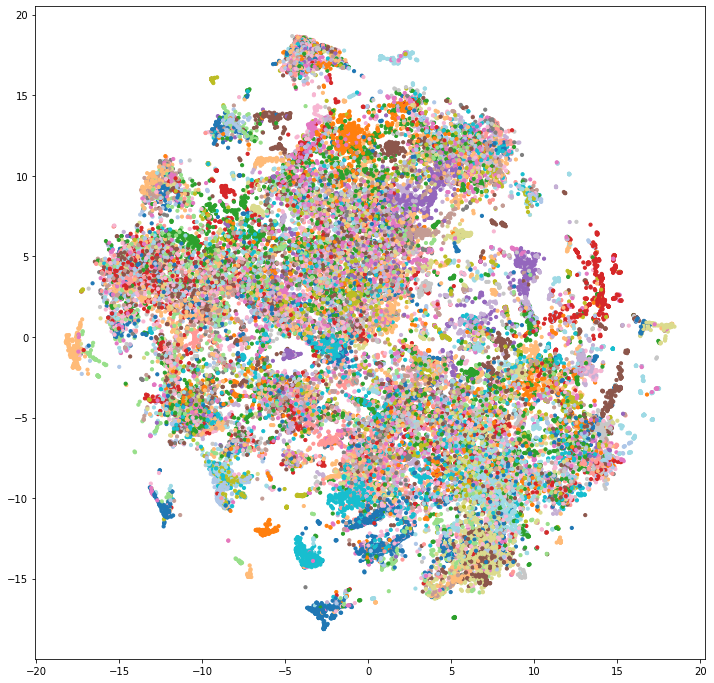

In [9]:
embeddings.visualize_embeddings(data_loader=data_loader, annotate_with="aisle_")

# Experiments

In [ ]:
product_to_key = {}
key_to_product = {}

for item_key, item_name in embeddings.product_key_conversion.items():
    product_to_key[item_name.split("\t")[0]] = item_key
    
key_to_product = {item_key: item_name for (item_name, item_key) in product_to_key.items()}

In [ ]:
def calculate_analogies(product_with_feature, product_without_feature, product_to_map_feature_onto):
    input_set = set([product_with_feature, product_without_feature, product_to_map_feature_onto])
    calculation = (embeddings.model.wv[product_to_key[product_with_feature]] - embeddings.model.wv[product_to_key[product_without_feature]]) + embeddings.model.wv[product_to_key[product_to_map_feature_onto]] 

    similar_by_vector = embeddings.model.wv.similar_by_vector(calculation, topn=15)

    return [(key_to_product[product_key], similarity) for product_key, similarity in similar_by_vector if key_to_product[product_key] not in input_set]

In [ ]:
# Organic
calculate_analogies(product_with_feature="Organic Banana", 
                    product_without_feature="Banana", 
                    product_to_map_feature_onto="Fuji Apples")

In [ ]:
# Frozen
calculate_analogies(product_with_feature="Frozen Organic Blueberries", 
                    product_without_feature="Organic Blueberries", 
                    product_to_map_feature_onto="Strawberries")

In [ ]:
# Unsweetened
calculate_analogies(product_with_feature="Unsweetened Almondmilk", 
                    product_without_feature="Original Almondmilk", 
                    product_to_map_feature_onto="Coconut Milk")

In [ ]:
# Low Fat
calculate_analogies(product_with_feature="Low Fat Plain Yogurt", 
                    product_without_feature="Whole Milk Plain Yogurt", 
                    product_to_map_feature_onto="Whole Milk")

In [ ]:
# Gluten Free
calculate_analogies(product_with_feature="Gluten Free Whole Grain Bread", 
                    product_without_feature="100% Whole Grain Bread", 
                    product_to_map_feature_onto="Multi Grain Waffles")

In [ ]:
# Sun-Dried
calculate_analogies(product_with_feature="Sun Dried Tomatoes", 
                    product_without_feature="Vine Ripe Tomatoes", 
                    product_to_map_feature_onto="Raw Goji Berries")

In [ ]:
# Spicy
calculate_analogies(product_with_feature="Spicy Hummus", 
                    product_without_feature="Original Hummus", 
                    product_to_map_feature_onto="Tomato Basil Pasta Sauce")

# Hyperparameter Search

In [ ]:
# We perform
# a hyperparameter search (300k models evaluated) on: the number of
# epochs n (10 to 200 with step of +10), the window-size L (3, 7, 12, 15),
# the sub-sampling parameter t (Eq. (2)) (10−5
# to 10−1 with step of ×10), the negative sampling distribution parameter α (Eq. (3)) (−1.4
# to 1.4 with step of +0.2), the embedding size (50 to 200 with a step
# of 50), the number of negative samples (5 to 20 with a step of 5) and
# the learning rate (0.0025 to 0.25 with a step of ×10). The marginal
# benefit of including the 3 latter variables to the optimization is not
# significant, with less than 2% in terms of performance. Thus, for
# readability, we only focus on the influence of the 4 first hyperparameters and keep the other fixed to default values (respectively
# 50, 5 and 0.025).

In [ ]:
def parameter_search(embeddings, train_data_iterator, validation_data, user_item_frequency, parameter_grid, min_count=10, k_neighbors=10, predict_k=10):
    results = []

    for params in parameter_grid:
        print(params['epochs'],
              params['window_sizes'],
              params['samples'],
              params['ns_exponents'],
              params['embedding_size'],
              params['numbers_of_negative_samples'])

        start = time.time()
        print(f"Parameters: {params}")

        # Train the model
        embeddings.train_model(
                            train_data=train_data_iterator,
                            epochs=params['epochs'],
                            embedding_size=params['embedding_size'],
                            window_size=params['window_sizes'],
                            min_count=min_count,
                            number_of_negative_samples=params['numbers_of_negative_samples'],
                            sample=params['samples'],
                            ns_exponent=params['ns_exponents'],
                            save=False,
                        )

        # Evaluate Embeddings
        category_f1, aisle_f1 = embeddings.evaluate_embeddings(k_neighbors=k_neighbors)
        
        # Create the Recommender
        item2vec_recommender = Item2VecRecommender(algorithm=embeddings.algorithm,
                                           item_key_mapping=embeddings.mapping,
                                           user_item_frequency=user_item_frequency,
                                           embedding_vectors=embeddings.embedding_vectors, 
                                           context_vectors=embeddings.context_vectors)
        
        # Within Basket Recommendations
        within_basket_validation = item2vec_recommender.evaluate(validation_data, 
                                                                 k=10, 
                                                                 within_basket=True)

        # test_auc, test_ndcg, test_recall, test_precision = item2vec_recommender.evaluate(test_data, 
        #                                                                                  k=10, 
        #                                                                                  within_basket=True)
        
        # Next Basket Recommendations
        next_basket_validation = item2vec_recommender.evaluate(validation_data, 
                                                                                     k=10, 
                                                                                     within_basket=False)

        # test_auc, test_ndcg, test_recall, test_precision = item2vec_recommender.evaluate(test_data, 
        #                                                                                  k=10, 
        #                                                                                  within_basket=False)

        results.append((params['epochs'], 
                        params['window_sizes'], 
                        params['samples'], 
                        params['ns_exponents'], 
                        params['embedding_size'],
                        params['numbers_of_negative_samples'],
                        category_f1[0], 
                        aisle_f1[0], 
                        category_f1[1], 
                        aisle_f1[1],
                        within_basket_validation[0], 
                        within_basket_validation[1],
                        within_basket_validation[2],
                        within_basket_validation[3],
                        next_basket_validation[0], 
                        next_basket_validation[1],
                        next_basket_validation[2],
                        next_basket_validation[3]
                       ))

    end = time.time()
    print(f"Took {end - start} seconds\n")

    # Sorting by best within basket AUC
    results.sort(key=lambda x: x[10], reverse=True)
        
    return results

In [ ]:
# epochs = [1]
# window_sizes = [100]
# samples = [0.01, 0.1] # 0.01
# ns_exponents = [0.25, 0.5, 0.75] # 0.5
# embedding_sizes = [128]
# numbers_of_negative_samples = [7]

param_grid_values = {'epochs': [1], 
                      'window_sizes': [100], 
                      'samples': [0.01, 0.1], 
                      'ns_exponents': [0.25, 0.5, 0.75], 
                      'embedding_size': [64, 128],
                      'numbers_of_negative_samples': [7, 14]}

parameter_grid = ParameterGrid(param_grid_values)

embeddings = Item2VecEmbeddings(algorithm="item2vec",
                                product_key_conversion=data_loader.product_key_conversion,
                                with_meta=False,
                                with_user=False)

results = parameter_search(embeddings=embeddings, 
                           train_data_iterator=data_loader.train_data_iterator, 
                           validation_data=data_loader.validation_data, 
                           user_item_frequency=data_loader.user_item_frequency, 
                           parameter_grid=parameter_grid, 
                           min_count=10, 
                           k_neighbors=10, 
                           predict_k=10)

In [ ]:
def save_results(results, algorithm):       
    results_path = f'{algorithm}_results.csv'
    
    results_df = pd.DataFrame(results, columns=[
                                            "Epoch", 
                                            "Window Size", 
                                            "Sample",
                                            "NS Exponent", 
                                            "Embedding Size", 
                                            "Number of Negative Samples",
                                            "F1 Macro Category",
                                            "F1 Macro Aisle",
                                            "F1 Micro Category",
                                            "F1 Micro Aisle",
                                            "Within-basket AUC",
                                            "Within-basket NDCG",
                                            "Within-basket Recall",
                                            "Within-basket Precision",
                                            "Next-basket AUC",
                                            "Next-basket NDCG",
                                            "Next-basket Recall",
                                            "Next-basket Precision"
                                          ])
    results_df.to_csv(results_path, index=False)

In [ ]:
# Write
with open(f'results/{algorithm}_parameter_search.txt', 'w') as f:
    for line in results:
        f.write(f"{str(line)}\n")

In [7]:
# Read
with open(f'results/{algorithm}_parameter_search.txt', 'r') as f:
    results = f.readlines()
    results = [eval(p.strip()) for p in results]

In [8]:
results_df = pd.DataFrame(results, columns=[
                                            "Epoch", 
                                            "Window Size", 
                                            "Sample",
                                            "NS Exponent", 
                                            "Embedding Size", 
                                            "Number of Negative Samples",
                                            "F1 Macro Category",
                                            "F1 Macro Aisle",
                                            "F1 Micro Category",
                                            "F1 Micro Aisle",
                                            "Within-basket AUC",
                                            "Within-basket NDCG",
                                            "Within-basket Recall",
                                            "Within-basket Precision",
                                            "Next-basket AUC",
                                            "Next-basket NDCG",
                                            "Next-basket Recall",
                                            "Next-basket Precision"
                                          ])
results_df.to_csv(f'results/{algorithm}/{small}results.csv', index=False)

In [ ]:
# Baseline (Triplet2Vec Paper) - Test set
# Item2Vec - Next Basket
# AUC  0.945 
# NDCG 0.111

# Item2Vec - Within Basket
# AUC  0.941 
# NDCG 0.116

# F1 Metrics Category
# Macro 0.377 
# Micro 0.283

# F1 Metrics Aisle
# Macro 0.187 
# Micro 0.075

In [ ]:
# Optimal Parameters
# Epoch: 5 (tradeoff for speed, but slightly better when its at 50)
# Sample: either 0.01 or 0.1 (quite a bit better than 0.001)
# NS Exponent: 0.5 (0.25 is a contender, both always outperforms 0.75, but 0.5 is slightly better)

In [9]:
# results_df = pd.read_csv(f'results/{algorithm}/{small}results.csv')
# results_df.sort_values("Sample", ascending=False)
column = "Embedding Size"

print(results_df.groupby(column)[["Within-basket AUC", "Next-basket AUC", "Within-basket NDCG", "Next-basket NDCG", "Within-basket Recall", "Next-basket Recall"]].mean())
print("\n#########################\n")
print(results_df.groupby(column)[["Within-basket AUC", "Next-basket AUC", "Within-basket NDCG", "Next-basket NDCG", "Within-basket Recall", "Next-basket Recall"]].median())

DataError: No numeric types to aggregate

In [10]:
correlation = results_df.corr(method='spearman')
correlation.style.background_gradient(cmap='coolwarm')

,Epoch,Window Size,Sample,NS Exponent,Embedding Size,Number of Negative Samples
Epoch,1.000000,0.251561,-0.152804,-0.300336,-0.133495,0.266670
Window Size,0.251561,1.000000,-0.170283,-0.371720,0.086054,0.410921
Sample,-0.152804,-0.170283,1.000000,0.174405,-0.073879,-0.240096
NS Exponent,-0.300336,-0.371720,0.174405,1.000000,-0.106849,-0.452133
Embedding Size,-0.133495,0.086054,-0.073879,-0.106849,1.000000,0.124978
Number of Negative Samples,0.266670,0.410921,-0.240096,-0.452133,0.124978,1.000000


In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
results_df["Avg. Recall"] = (results_df["Within-basket Recall"] + results_df["Next-basket Recall"]) /2
results_df.sort_values("Avg. Recall", ascending=False)